# CausalInsights : Marketing Campaign Optimizer

✅ **Project Overview**

This project aims to measure the true causal impact of marketing campaigns on customer purchasing behavior using causal inference techniques. Traditional machine learning often captures correlations and predictions but cannot reliably infer cause and effect. Our goal is to use **uplift modeling** and **treatment effect estimation** to identify **which customers are influenced by the campaign — and by how much.**

✅ **Dataset Overview**

We use the [Hillstrom Email Marketing Dataset](https://www.kaggle.com/datasets/bofulee/kevin-hillstrom-minethatdata-e-mailanalytics), a well-known benchmark dataset that simulates a realistic e-commerce marketing campaign with customers randomly assigned to treatment (marketing email) or control (no email) groups. The dataset includes customer demographics, purchase history, campaign assignment, and outcomes like purchase amount and conversion.

✅ **Core Concepts to Apply**



*   **Uplift Modeling:** To estimate the incremental impact of the email campaign on each customer’s purchase behavior.

*   **Treatment Effect Estimation:** To calculate both Average Treatment Effect (ATE) — the overall campaign impact, and Conditional Average Treatment Effect (CATE) — impact on specific customer subgroups.


*  **A/B Testing Simulation:** The dataset mimics an A/B test framework, providing a solid foundation for causal inference.

*  **DoWhy Framework:** To explicitly encode causal assumptions, construct causal graphs, identify estimands, estimate effects, and perform refutation tests.

*  **EconML:** To implement state-of-the-art uplift estimators and estimate heterogeneous treatment effects.







✅ **Data Preprocessing with Exploratory Data Analysis (EDA)**

In [ ]:
#load the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
#Load the data
data = pd.read_csv('/content/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
print(data.shape)  # return no of rows, cols
print(data.info())
print(data.head())
print(data.describe())

(64000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB
None
   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1       

In [ ]:
print(data['segment'].value_counts())  # Treatment groups
print(data['spend'].describe())
print(data['conversion'].value_counts())

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64
count    64000.000000
mean         1.050908
std         15.036448
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        499.000000
Name: spend, dtype: float64
conversion
0    63422
1      578
Name: count, dtype: int64


Create 'treatment' and 'converted' columns

In [ ]:
data['treatment'] = data['segment'].apply(lambda x: 0 if x == 'No E-Mail' or pd.isna(x) or x == '' else 1)


In [ ]:
data['converted'] = (data['spend'] > 0).astype(int)


Treatment and Control Group Balance

We will examine whether the treatment and control groups are balanced with respect to customers' purchase history prior to the campaign. A boxplot and histogram help us visualize the distribution across groups.

Checking balance for 'history':
             count        mean         std    min    25%      50%       75%  \
treatment                                                                     
0          21306.0  240.882653  252.739362  29.99  65.30  156.655  325.1675   
1          42694.0  242.686002  257.848830  29.99  64.35  158.870  325.7800   

               max  
treatment           
0          3345.93  
1          3215.97  


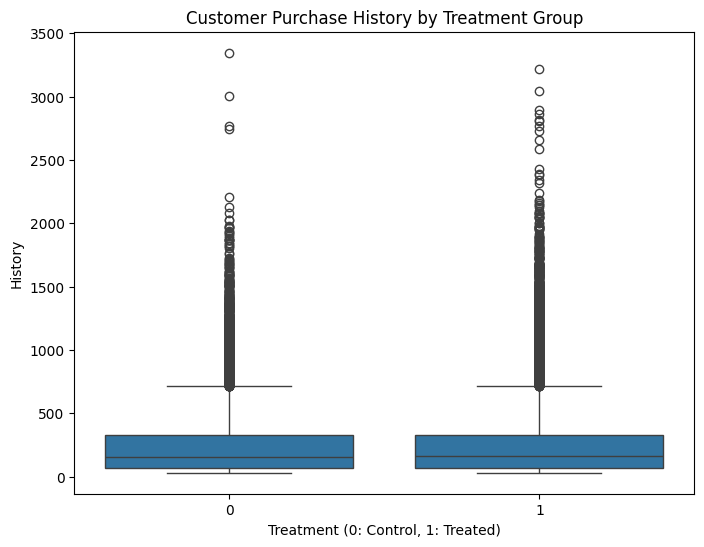

In [ ]:
print("Checking balance for 'history':")
print(data.groupby('treatment')['history'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='history', data=data)
plt.title('Customer Purchase History by Treatment Group')
plt.xlabel('Treatment (0: Control, 1: Treated)')
plt.ylabel('History')
plt.show()

✅ Conclusion: The distributions of history are roughly similar across treatment groups, suggesting balance in this covariate.

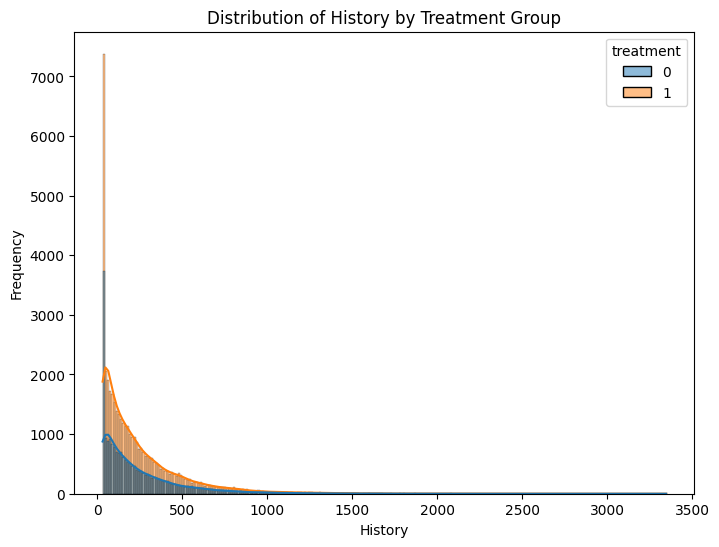

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='history', hue='treatment', kde=True)
plt.title('Distribution of History by Treatment Group')
plt.xlabel('History')
plt.ylabel('Frequency')
plt.show()

✅ Conclusion: The distribution is highly right-skewed for both the control and treatment groups,making it a suitable variable to include without heavy adjustment.


Check balance of a categorical covariate

Next, we examine if the distribution of communication channels (Email, Web, Phone) is similar across treatment groups.


Checking balance for 'channel':
treatment  channel     
0          Web             0.439923
           Phone           0.437764
           Multichannel    0.122313
1          Web             0.441373
           Phone           0.437860
           Multichannel    0.120766
Name: proportion, dtype: float64


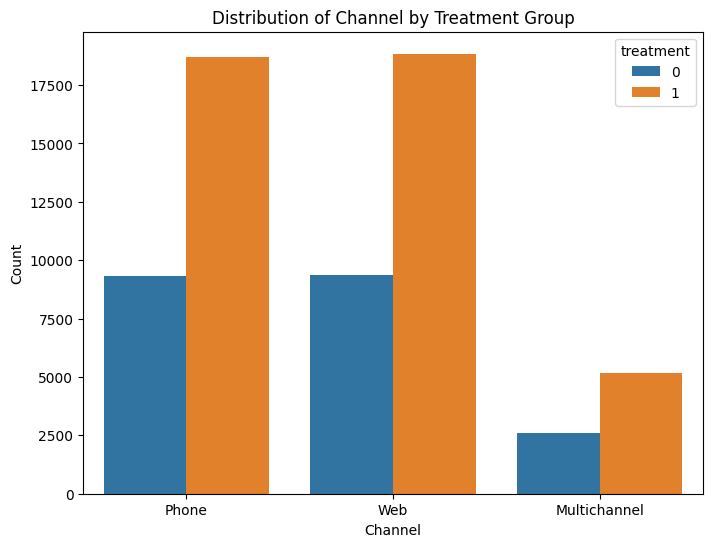

In [ ]:
print("\nChecking balance for 'channel':")
print(data.groupby('treatment')['channel'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='channel', hue='treatment')
plt.title('Distribution of Channel by Treatment Group')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()


✅ Conclusion: There is a noticeable imbalance in the use of communication channels between treatment groups, which may act as a confounder and should be accounted for in the causal model.

**Relationship between Treatment and Outcomes (Preliminary ATE Estimation)**


Compare mean spend between groups

We now assess the causal effect of the marketing campaign on customer spending.

Mean Spend by Treatment Group:
treatment
0    0.652789
1    1.249585
Name: spend, dtype: float64


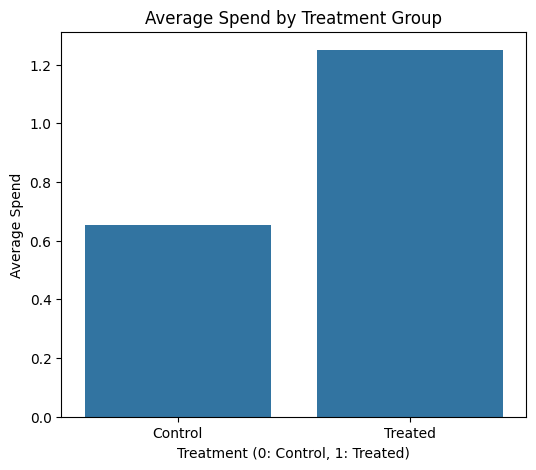

In [ ]:
mean_spend_by_group = data.groupby('treatment')['spend'].mean()
print(f"Mean Spend by Treatment Group:\n{mean_spend_by_group}")

plt.figure(figsize=(6, 5))
sns.barplot(x=mean_spend_by_group.index, y=mean_spend_by_group.values)
plt.title('Average Spend by Treatment Group')
plt.xlabel('Treatment (0: Control, 1: Treated)')
plt.ylabel('Average Spend')
plt.xticks([0, 1], ['Control', 'Treated'])
plt.show()


✅ Conclusion: Customers in the treatment group tend to spend more on average than those in the control group. This suggests a positive impact of the marketing intervention on revenue.

 Compare conversion rate between groups

Next, we evaluate the effect of the treatment on the conversion rate (whether the customer made a purchase).


Conversion Rate by Treatment Group:
treatment
0    0.005726
1    0.010681
Name: converted, dtype: float64


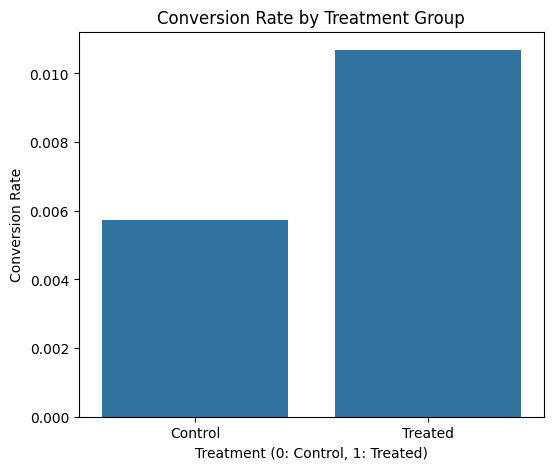

In [ ]:
conversion_rate_by_group = data.groupby('treatment')['converted'].mean()
print(f"\nConversion Rate by Treatment Group:\n{conversion_rate_by_group}")

plt.figure(figsize=(6, 5))
sns.barplot(x=conversion_rate_by_group.index, y=conversion_rate_by_group.values)
plt.title('Conversion Rate by Treatment Group')
plt.xlabel('Treatment (0: Control, 1: Treated)')
plt.ylabel('Conversion Rate')
plt.xticks([0, 1], ['Control', 'Treated'])
plt.show()

✅ Conclusion: The treatment group shows a higher conversion rate than the control group, indicating the campaign successfully increased customer purchases.

**Exploring Potential Effect Heterogeneity (Setting the Stage for CATE)**



Exploring Heterogeneity (Conversion Rate by History Segment and Treatment):


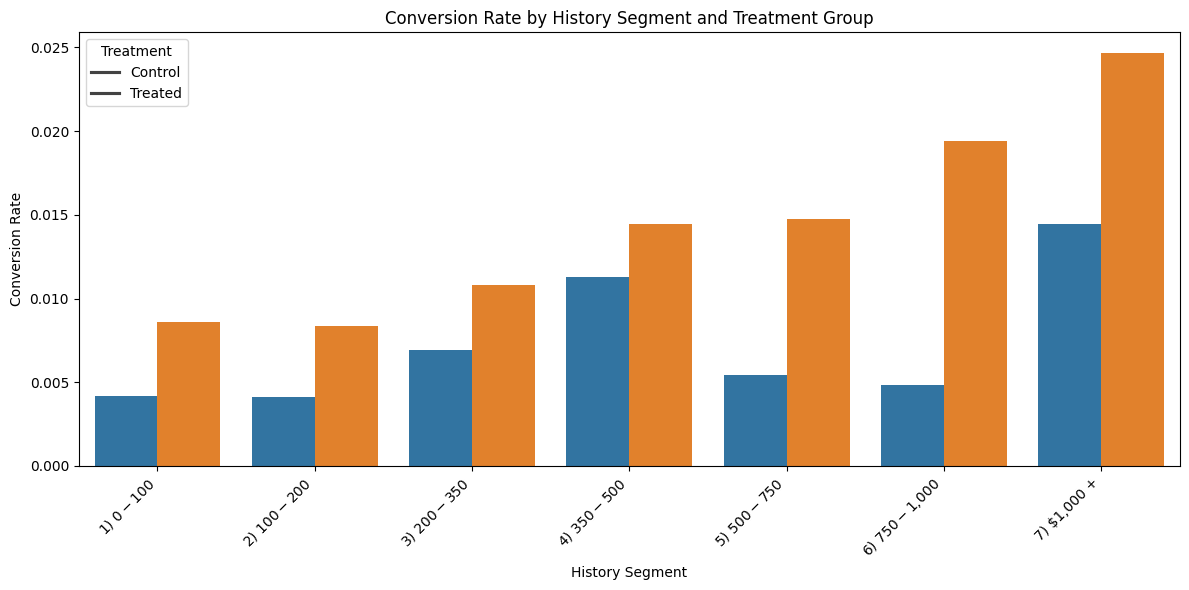

In [ ]:
print("\nExploring Heterogeneity (Conversion Rate by History Segment and Treatment):")
conversion_by_history_segment_treatment = data.groupby(['history_segment', 'treatment'])['converted'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='history_segment', y='converted', hue='treatment', data=conversion_by_history_segment_treatment)
plt.title('Conversion Rate by History Segment and Treatment Group')
plt.xlabel('History Segment')
plt.ylabel('Conversion Rate')
plt.legend(title='Treatment', labels=['Control', 'Treated'])
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()



✅ Conclusion

Treated groups have higher conversion rates in all segments.

Highest uplift in high-value segments ($1000+).

Minimal uplift in mid-value segments.


Exploring Heterogeneity (Average Spend by History Segment and Treatment):


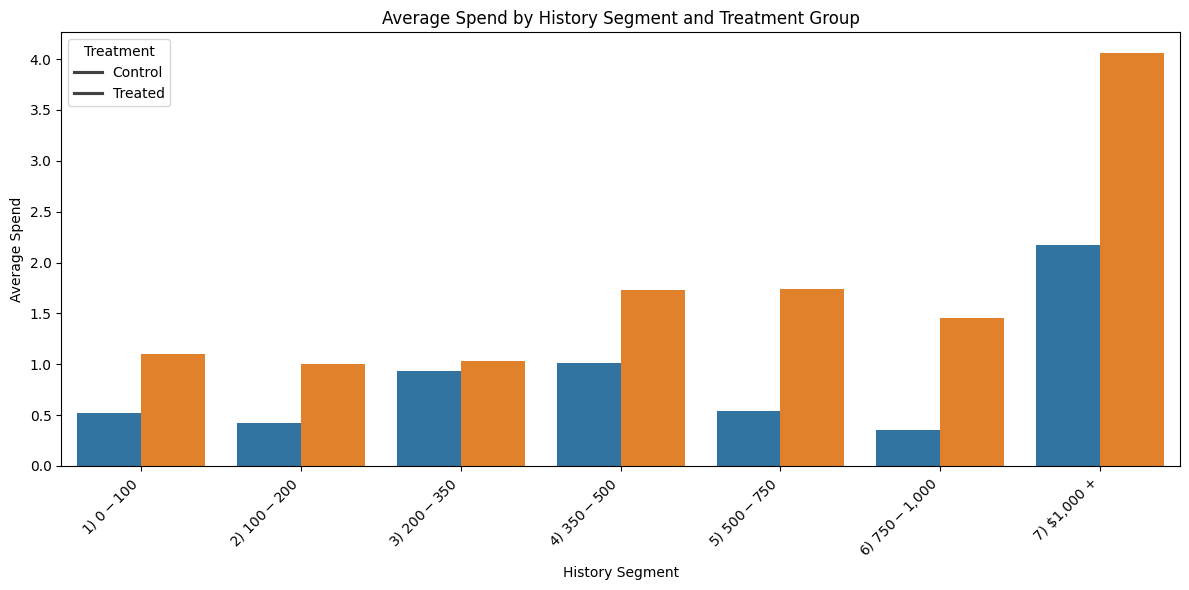

In [ ]:
print("\nExploring Heterogeneity (Average Spend by History Segment and Treatment):")
spend_by_history_segment_treatment = data.groupby(['history_segment', 'treatment'])['spend'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='history_segment', y='spend', hue='treatment', data=spend_by_history_segment_treatment)
plt.title('Average Spend by History Segment and Treatment Group')
plt.xlabel('History Segment')
plt.ylabel('Average Spend')
plt.legend(title='Treatment', labels=['Control', 'Treated'])
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

✅ Conclusion

1. Treated groups spend more across all segments.

2. Largest spend increase in "$1,000+" segment.

3. Low uplift in lower and mid segments
  








Explore heterogeneity based on other categorical covariates like 'channel' and 'zip_code'



Exploring Heterogeneity (Conversion Rate by Channel and Treatment):


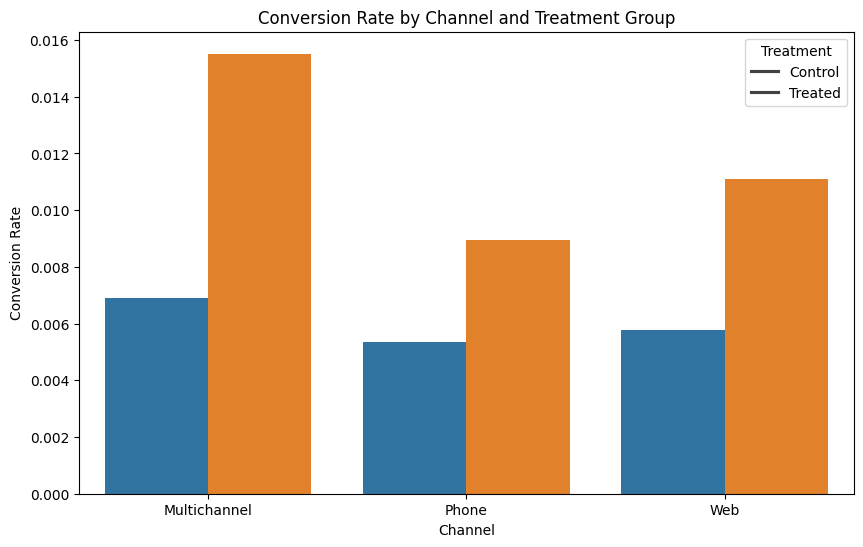

In [ ]:
print("\nExploring Heterogeneity (Conversion Rate by Channel and Treatment):")
conversion_by_channel_treatment = data.groupby(['channel', 'treatment'])['converted'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='converted', hue='treatment', data=conversion_by_channel_treatment)
plt.title('Conversion Rate by Channel and Treatment Group')
plt.xlabel('Channel')
plt.ylabel('Conversion Rate')
plt.legend(title='Treatment', labels=['Control', 'Treated'])
plt.show()



✅ Conclusion:

* Treatment boosts conversion for all channels.

* The Multichannel group shows the highest uplift, meaning users reached through multiple channels respond best.

* The Web channel shows a moderate lift.

*The Phone channel has the smallest gain, suggesting it is the least responsive group to treatment






Exploring Heterogeneity (Conversion Rate by Zip Code and Treatment):


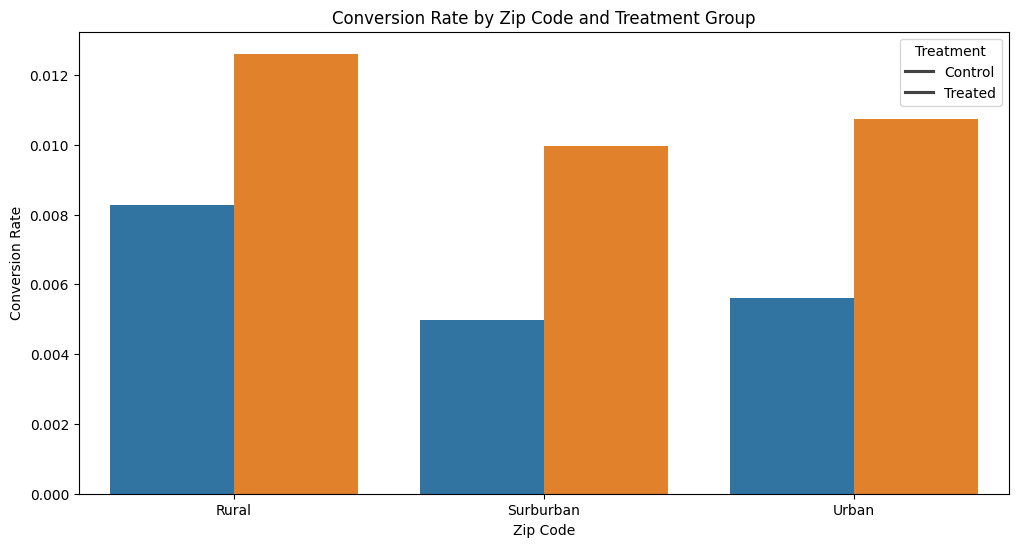

In [ ]:
print("\nExploring Heterogeneity (Conversion Rate by Zip Code and Treatment):")
conversion_by_zip_code_treatment = data.groupby(['zip_code', 'treatment'])['converted'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='zip_code', y='converted', hue='treatment', data=conversion_by_zip_code_treatment)
plt.title('Conversion Rate by Zip Code and Treatment Group')
plt.xlabel('Zip Code')
plt.ylabel('Conversion Rate')
plt.legend(title='Treatment', labels=['Control', 'Treated'])
plt.show()



✅Conclusion:

* The treatment increases conversion rates across all zip codes.
* However, the Rural group shows the highest lift from control to treatment, suggesting the treatment is most effective for rural users.

* Suburban and Urban users also respond positively, but with slightly smaller gains.







Exploring Heterogeneity (Conversion Rate by Newbie and Treatment):


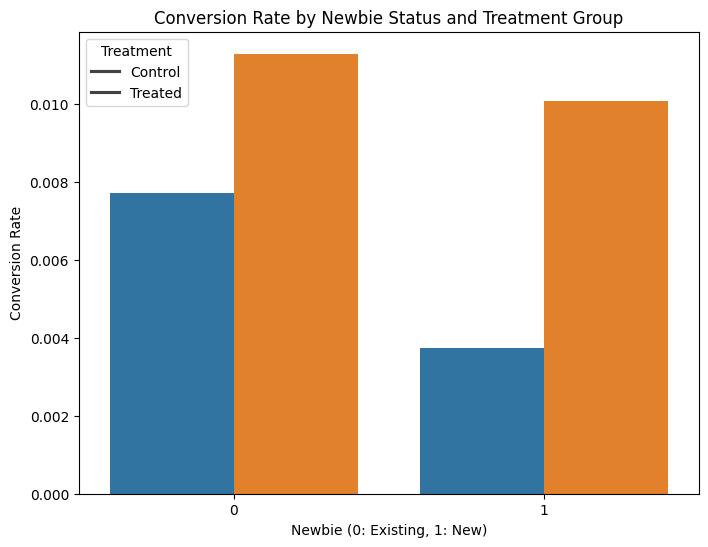

In [44]:
print("\nExploring Heterogeneity (Conversion Rate by Newbie and Treatment):")
conversion_by_newbie_treatment = data.groupby(['newbie', 'treatment'])['converted'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='newbie', y='converted', hue='treatment', data=conversion_by_newbie_treatment)
plt.title('Conversion Rate by Newbie Status and Treatment Group')
plt.xlabel('Newbie (0: Existing, 1: New)')
plt.ylabel('Conversion Rate')
plt.legend(title='Treatment', labels=['Control', 'Treated'])
plt.show()

✅ Conclusion -

* The treatment effect is stronger for new users than for existing users

* This suggests that the treatment is more effective for onboarding or engaging new users





In [ ]:
data.to_csv('processed_data.csv', index=False)

print("Processed data saved to processed_data.csv")

Processed data saved to processed_data.csv
